1. Install Python Libraries

In [41]:
%pip install --quiet --upgrade biopython pandas matplotlib

from pathlib import Path
from Bio import Entrez, SeqIO, Seq
from Bio.SeqUtils import gc_fraction
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np, pandas as pd
import re
from typing import Mapping

Note: you may need to restart the kernel to use updated packages.


Configure Entrez

In [42]:
Entrez.email = "pandey.aka@northeastern.edu"
Entrez.tool  = "biopython"                  


Helper: fetch FASTA from NCBI

In [43]:
def fetch_fasta(accession: str, out_fasta: Path | None = None) -> Seq.Seq:
    
    try:
        with Entrez.efetch(db="nucleotide",
                           id=accession,
                           rettype="fasta",
                           retmode="text") as handle:
            record = SeqIO.read(handle, "fasta")
    except Exception as exc:
        raise RuntimeError(f"NCBI fetch failed for {accession}: {exc}") from exc

    if out_fasta:
        out_fasta.parent.mkdir(parents=True, exist_ok=True)
        SeqIO.write(record, out_fasta, "fasta")

    return record


Fetch the genome


In [44]:
# Human chr 17 (GRCh38)
accession   = "NC_000017.11"        
fasta_path  = Path("data") / f"{accession}.fasta"

record = fetch_fasta(accession, fasta_path)
seq    = record.seq


Quick summary

In [45]:
print(f"ID            : {record.id}")
print(f"Description   : {record.description}")
print(f"Length (bp)   : {len(seq):,}")
print(f"GC-content    : {gc_fraction(seq)*100:.2f}%")
print(f"First 100 nt  : {seq[:100]}…")


ID            : NC_000017.11
Description   : NC_000017.11 Homo sapiens chromosome 17, GRCh38.p14 Primary Assembly
Length (bp)   : 83,257,441
GC-content    : 45.32%
First 100 nt  : NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN…


Counting Frequencies

In [46]:
IUPAC_GC_WEIGHT = {
    'A':0, 'T':0, 'G':1, 'C':1,
    'R':0.5, 'Y':0.5, 'M':0.5, 'K':0.5,   
    'S':1,   'W':0,
    'B':2/3, 'V':2/3,                     
    'D':1/3, 'H':1/3,
    'N':0                              
}

def gc_ignore_amb(seq: str) -> float:
    """GC% using only unambiguous A/T/C/G bases."""
    seq = seq.upper()
    counts = Counter(b for b in seq if b in "ATCG")
    atcg   = counts['A'] + counts['T'] + counts['C'] + counts['G']
    return 100 * (counts['G'] + counts['C']) / atcg if atcg else 0.0

def gc_weighted(seq: str) -> float:
    """GC% using IUPAC weights for ambiguous symbols."""
    seq = seq.upper()
    gc   = sum(IUPAC_GC_WEIGHT.get(b, 0) for b in seq)
    tot  = sum(1 if b in "ATCG" else IUPAC_GC_WEIGHT.get(b, 1) for b in seq)
    return 100 * gc / tot if tot else 0.0

Figure saved → /Users/akanksha/Projects/nucleotide_composition.png


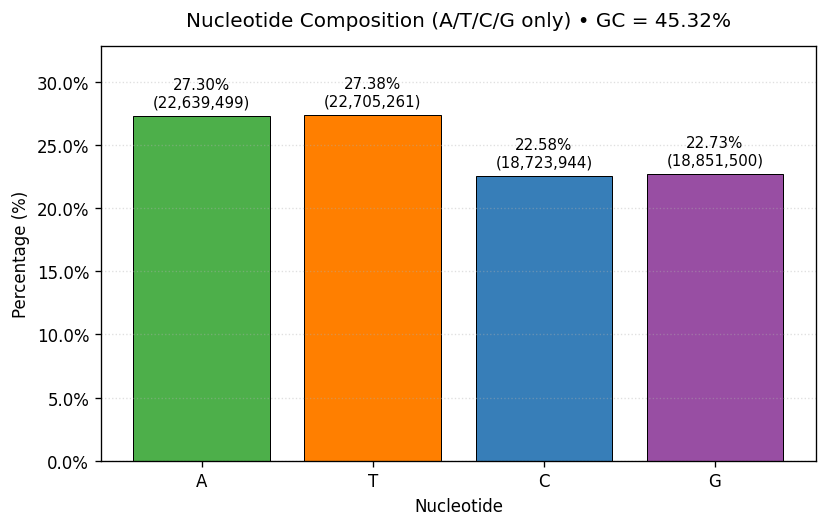

Base counts (A/T/C/G): {'A': 22639499, 'T': 22705261, 'C': 18723944, 'G': 18851500}
GC% (ignore ambiguities): 45.32%
GC% (IUPAC weighted)  : 45.32%


In [47]:
def plot_base_composition(
    seq: str,
    save_png: str | Path | None = None,
    title: str | None = None
):
    """
    Plot % composition for A/T/C/G only (ambiguities ignored).

    Parameters
    ----------
    seq : str
        DNA sequence.
    save_png : str or Path or None
        Optional filename to save the figure (300 dpi).
    title : str or None
        Figure title.  If None, a default title with GC% is used.
    """
    seq = seq.upper()
    wanted = ['A', 'T', 'C', 'G']
    counts_full = Counter(seq)
    counts = {b: counts_full.get(b, 0) for b in wanted}
    total  = sum(counts.values())

    pct = {b: (counts[b] / total) * 100 if total else 0 for b in wanted}
    gc  = pct['G'] + pct['C']

    
    fig, ax = plt.subplots(figsize=(7, 4.5), dpi=120)
    bars = ax.bar(
        wanted,
        [pct[b] for b in wanted],
        color=['#4daf4a', '#ff7f00', '#377eb8', '#984ea3'], 
        edgecolor='black',
        linewidth=0.6
    )

    # Labels on bars
    for bar, base in zip(bars, wanted):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,
            f"{pct[base]:.2f}%\n({counts[base]:,})",
            ha="center", va="bottom", fontsize=9
        )

    ax.set_xlabel("Nucleotide")
    ax.set_ylabel("Percentage (%)")
    ax.yaxis.set_major_formatter(PercentFormatter())
    ax.set_ylim(0, max(pct.values()) * 1.20 if pct else 1)

    if title is None:
        title = f"Nucleotide Composition (A/T/C/G only) • GC = {gc:.2f}%"
    ax.set_title(title, pad=12, fontsize=12)

    ax.grid(axis='y', linestyle=':', alpha=0.4)
    plt.tight_layout()

    # Optional file output
    if save_png:
        plt.savefig(save_png, dpi=300)
        print(f"Figure saved → {Path(save_png).resolve()}")

    plt.show()

    # Console summary
    print("Base counts (A/T/C/G):", counts)
    print(f"GC% (ignore ambiguities): {gc_ignore_amb(seq):.2f}%")
    print(f"GC% (IUPAC weighted)  : {gc_weighted(seq):.2f}%")


plot_base_composition(seq, save_png="nucleotide_composition.png")


Sliding-window GC %

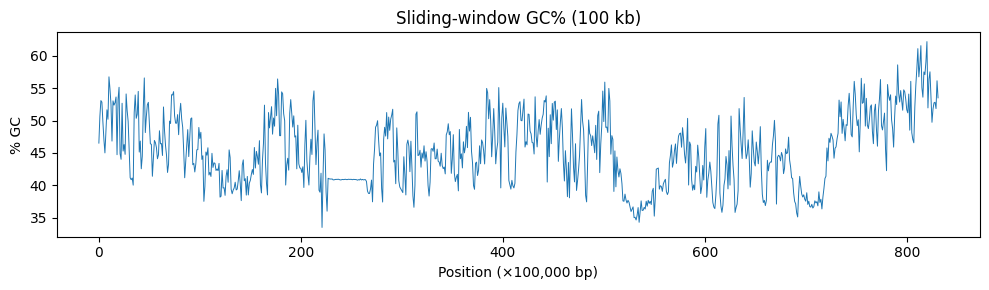

In [48]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
win  = 100_000                                   # 100 kb
gc   = pd.Series([gc_ignore_amb(seq[i:i+win]) 
                  for i in range(0, len(seq)-win, win)])

fig, ax = plt.subplots(figsize=(10,3))
gc.plot(ax=ax, lw=0.7)
ax.set_xlabel(f'Position (×{win:,} bp)')
ax.set_ylabel('% GC')
ax.set_title('Sliding-window GC% (100 kb)')
plt.tight_layout()
plt.show()


k-mer

In [49]:
def kmer_counts(seq: str, k: int = 4, *, ignore_amb=True) -> Counter:
    """
    Return a Counter of all k-mers in *seq*.

    Parameters
    ----------
    seq : str
        Input DNA sequence.
    k : int
        k-mer length (≥1)  
    """
    seq = seq.upper()
    n = len(seq)
    out = Counter()

    if k < 1:
        raise ValueError("k must be ≥ 1")

    for i in range(n - k + 1):
        kmer = seq[i : i + k]
        if ignore_amb and set(kmer) - set("ATCG"):
            continue
        out[kmer] += 1

    return out





In [50]:
k = 4                          
counts = kmer_counts(seq, k=k, ignore_amb=True)

print(f"{len(counts):,} unique {k}-mers found.")
print("Most common:")
for kmer, c in counts.most_common(10):
    print(f"  {kmer} : {c:,}")

256 unique 4-mers found.
Most common:
  TTTT : 1,155,443
  AAAA : 1,154,757
  ATTT : 637,985
  AAAT : 628,573
  CAGG : 597,688
  AGAA : 597,553
  CCTG : 592,328
  TTTG : 589,846
  CCAG : 588,769
  CTGG : 583,194


Calculate CpG density/islands

In [51]:

def gc_and_oe(window: str) -> tuple[float, float]:
    """
    Return (%GC, CpG observed/expected) for *window*.
    """
    window = window.upper()
    counts = Counter(window)
    g = counts['G']
    c = counts['C']
    n = len(window)
    cg_obs = window.count("CG")
    # expected = freq(C) * freq(G) * n_windows_minus1
    cg_exp = (c / n) * (g / n) * (n - 1) if n > 1 else 0
    oe = (cg_obs / cg_exp) if cg_exp else 0
    gc_pct = 100 * (g + c) / n if n else 0
    return gc_pct, oe

def find_cpg_islands(
    seq: str,
    window: int = 200,
    min_gc: float = 50.0,
    min_oe: float = 0.6,
    step: int = 1
) -> pd.DataFrame:
    """
    Identify CpG islands with the Gardiner-Garden & Frommer (1987) definition.

    Parameters
    ----------
    seq      : DNA sequence (string).
    window   : Sliding-window size in bp (default 200).
    min_gc   : Minimum GC% to call an island (default 50).
    min_oe   : Minimum observed/expected CpG ratio (default 0.6).
    step     : Window shift (1 = every bp; use 100–500 for speed on huge genomes).

    Returns
    -------
    DataFrame with columns: start, end, length, gc_pct, oe
    """
    seq = seq.upper()
    n   = len(seq)
    hits = []

    i = 0
    while i + window <= n:
        win = seq[i : i + window]
        gc_pct, oe = gc_and_oe(win)
        if gc_pct >= min_gc and oe >= min_oe:
            # extend to the right until criteria fail
            start = i
            end   = i + window
            while end + window <= n:
                next_win = seq[end : end + window]
                next_gc, next_oe = gc_and_oe(next_win)
                if next_gc < min_gc or next_oe < min_oe:
                    break
                end += step
            hits.append((start, end, end - start, gc_pct, oe))
            i = end  # jump past island
        else:
            i += step

    cols = ["start", "end", "length", "gc_pct", "oe"]
    return pd.DataFrame(hits, columns=cols)


islands = find_cpg_islands(seq, window=200, min_gc=50, min_oe=0.6, step=50)






In [52]:
# summary
genome_len   = len(seq)
total_isl_bp = islands["length"].sum()
print(f"CpG islands found : {len(islands):,}")
print(f"Total island bp   : {total_isl_bp:,}  "
      f"({total_isl_bp / genome_len * 100:.2f}% of sequence)")
print(f"Island density    : {len(islands) / (genome_len / 1_000_000):.1f} islands / Mb")

CpG islands found : 16,262
Total island bp   : 4,343,450  (5.22% of sequence)
Island density    : 195.3 islands / Mb


Identifying low-complexity / repetitive DNA

In [ ]:
def dust_mask(seq: str, window: int = 64, threshold: int = 20) -> str:
    """
    Return *seq* with low-complexity regions soft-masked (lower-case).
    """
    seq = seq.upper()
    n   = len(seq)
    to_mask = np.zeros(n, dtype=bool)

    # precompute triplets for speed
    triplets = [seq[i : i + 3] for i in range(n - 2)]

    for i in range(n - window + 1):                
        win_tris = triplets[i : i + window - 2]    
        counts   = Counter(win_tris)
        score    = sum(c * (c - 1) // 2 for c in counts.values())
        score    = score * 10 / (window - 2)     
        if score > threshold:
            to_mask[i : i + window] = True

    # build masked string
    masked = ''.join(
        base.lower() if mask else base
        for base, mask in zip(seq, to_mask)
    )
    return masked
masked_seq = dust_mask(seq)





In [ ]:
# stats
total_bp   = len(seq)
masked_bp  = sum(1 for b in masked_seq if b.islower())
coverage   = masked_bp / total_bp * 100

print(f"Total length     : {total_bp:,} bp")
print(f"Masked positions : {masked_bp:,} bp  ({coverage:.2f} %)")
print(f"Unmasked (upper) : {total_bp - masked_bp:,} bp")

In [ ]:
# Density array: fraction masked per 1-kb bin
bin_size = 1_000
fractions = [
    sum(ch.islower() for ch in seq[i : i + bin_size]) / len(masked_seq[i : i + bin_size])
    for i in range(0, total_bp, bin_size)
]
bins = np.asarray(fractions, dtype=float)

fig, ax = plt.subplots(figsize=(10, 2.5), dpi=120)
ax.plot(np.arange(len(bins)) * bin_size / 1e6, bins, lw=1)
ax.set_xlabel("Position (Mb)")
ax.set_ylabel("Fraction masked per 1 kb")
ax.set_ylim(0, 1)
ax.set_title("Low-complexity (Repeat-masked) density")
plt.tight_layout()
plt.show()


In [ ]:
def find_patterns_regex(
    seq,                       
    patterns,
    *,
    allow_overlap=True,
    flags=re.IGNORECASE
):
    if isinstance(patterns, str):
        patterns = [patterns]

    seq = str(seq).upper()     
    hits = defaultdict(list)

    for pat in patterns:
        regex = pat
        if allow_overlap:
            regex = f"(?=({regex}))"
        compiled = re.compile(regex, flags=flags)

        for m in compiled.finditer(seq):
            start = m.start()
            match_txt = m.group(1) if allow_overlap else m.group()
            end = start + len(match_txt)

            hits["pattern"].append(pat)
            hits["start"].append(start)
            hits["end"].append(end)
            hits["match"].append(match_txt)

    return (
        pd.DataFrame(hits)
        .sort_values(["pattern", "start"])
        .reset_index(drop=True)
    )
df_hits = find_patterns_regex(seq, motifs, allow_overlap=False)
print(df_hits)

In [ ]:
def find_patterns_regex(
    seq: str,
    patterns: list[str] | str,
    *,
    allow_overlap: bool = True,
    flags: int = re.IGNORECASE
) -> pd.DataFrame:
    
    if isinstance(patterns, str):
        patterns = [patterns]

    seq = seq.upper()
    hits = defaultdict(list)

    for pat in patterns:
        regex = pat
        if allow_overlap:
            regex = f"(?=({regex}))"     
        compiled = re.compile(regex, flags=flags)

        for m in compiled.finditer(str(seq)):
            span_start = m.start()
            match_txt  = m.group(1) if allow_overlap else m.group()
            span_end   = span_start + len(match_txt)

            hits["pattern"].append(pat)
            hits["start"].append(span_start)
            hits["end"].append(span_end)
            hits["match"].append(match_txt)

    return (
        pd.DataFrame(hits)
        .sort_values(["pattern", "start"])
        .reset_index(drop=True)
    )

motifs = [
    "CGCG",         # exact 4-mer
    "GTA..",        # regex: ATG followed by any 2 bases
    "GG[AT]GG"      # regex class
]

df_hits = find_patterns_regex(
    dna_sequence,
    motifs,
    allow_overlap=False  
)

print(f"{len(df_hits):,} total matches")
display(df_hits.head())


Transcribe a DNA sequence to RNA

In [ ]:

_DNA2RNA = str.maketrans("Tt", "Uu")

def transcribe_dna(seq) -> str:
    """
    Transcribe DNA (string or Bio.Seq) to RNA.
    Converts T/t → U/u.
    Raises if the sequence already contains U/u.
    """
    s = str(seq)                       
    if "U" in s.upper():
        raise ValueError("Input appears to be RNA already (contains 'U').")
    return s.translate(_DNA2RNA)      


# Preview the first 100 bases

rna_seq = transcribe_dna(dna_sequence)
print(rna_seq[:100])


Reverse complement of a DNA sequence

In [ ]:
# Full IUPAC complement map (upper + lower case)
_IUPAC_COMP: Mapping[str, str] = str.maketrans(
    "ACGTRYMKHBVDNacgtrymkhbvdn",   # originals
    "TGCAYRKMDBVHNtgcayrkmd bvh n"  # complements
    .replace(" ", "")               # keep layout readable
)

def complement(seq) -> str:
    """Return the complement of a DNA sequence (string or Bio.Seq)."""
    return str(seq).translate(_IUPAC_COMP)

def reverse_complement(seq) -> str:
    """Return the reverse-complement of a DNA sequence."""
    return complement(seq)[::-1]


frag        = str(dna_sequence)[:100]      # first 100 bases of your chromosome
comp        = complement(frag)
revcomp     = reverse_complement(frag)


bars = "".join("|" if b.upper() in "ATCG" else " " for b in frag)

print("DNA template, complement, and reverse complement (first 100 nt)\n")
print(f"5' {frag} 3'")
print(f"   {bars}")
print(f"3' {comp[::-1]} 5'  [complement]")
print(f"5' {revcomp} 3'  [reverse-complement]")

DNA to Amino Acid Translation

In [ ]:
# 1. Translators

from Bio.Seq import Seq
from Bio.Data import CodonTable

def translate_dna(
    seq, *,
    frame: int = 1,
    table: int | str = 1,     
    to_stop: bool = False,
    trim: str | None = "X"    
) -> str:
    """
    Translate DNA (or RNA) → amino-acid sequence.
    Returns protein (str)
    """
    if frame not in (1, 2, 3):
        raise ValueError("frame must be 1, 2, or 3")

    s = str(seq).upper().replace("U", "T")        
    s = s[frame - 1:]                             

    if len(s) % 3:
        if trim == "X":
            pad = 3 - (len(s) % 3)
            s += "N" * pad                       
        elif trim == "":
            s = s[: len(s) - (len(s) % 3)]
        else:
            raise ValueError("Sequence length not a multiple of 3")

    prot = Seq(s).translate(
        table=table,
        to_stop=to_stop,
        cds=False,            
        gap=None
    )
    return str(prot)


# translate the first 90 nt in all 3 frames

snippet = dna_sequence[:90]    

for f in (1, 2, 3):
    aa = translate_dna(snippet, frame=f)
    print(f"Frame {f}: {aa}")
